# Compiling & Visualizing Tracr Models

This notebook demonstrates how to compile a tracr model and provides some tools visualize the model's residual stream or layer outputs for a given input sequence.

In [4]:
#@title Imports
import jax
import numpy as np
import matplotlib.pyplot as plt

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [3]:
#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


In [2]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [5]:
program_name = "sort"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
max_seq_len = 10  #@param {label: "Test", type: "integer"}

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)


In [6]:
#@title: Assemble model
program_name = "sort"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
max_seq_len = 10  #@param {label: "Test", type: "integer"}

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=max_seq_len,
      causal=False,
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

print("Done.")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Compiling...
   Program: sort
   Input vocabulary: {1, 2, 3, 4, 5}
   Context size: 10
Done.


In [7]:
#@title Forward pass
assembled_model.apply(["bos", 3,4,1,5,2]).decoded

['bos', 1, 2, 3, 4, 5]

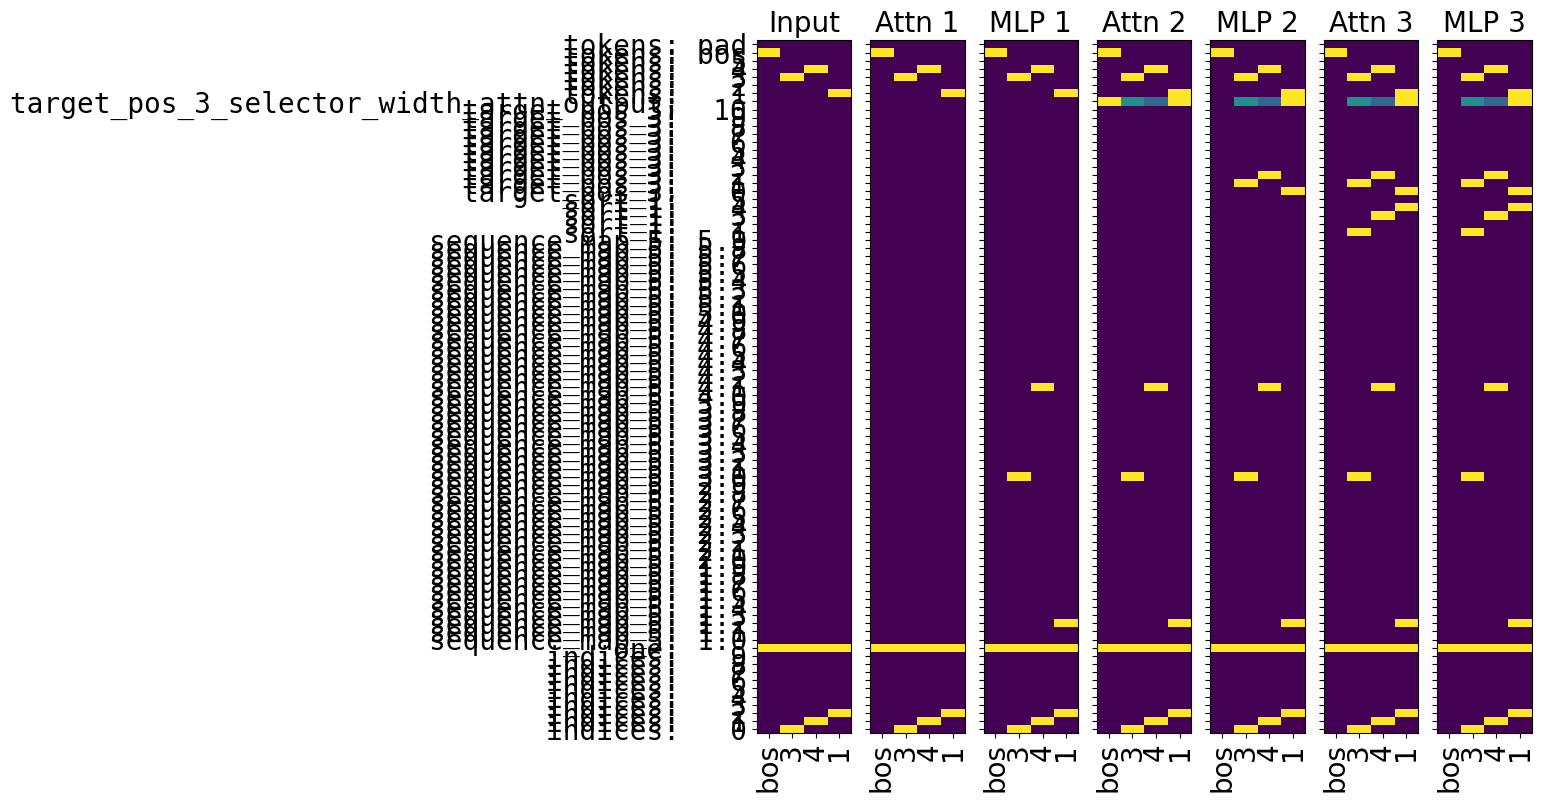

In [8]:
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1],
  figsize=(10, 9)
)

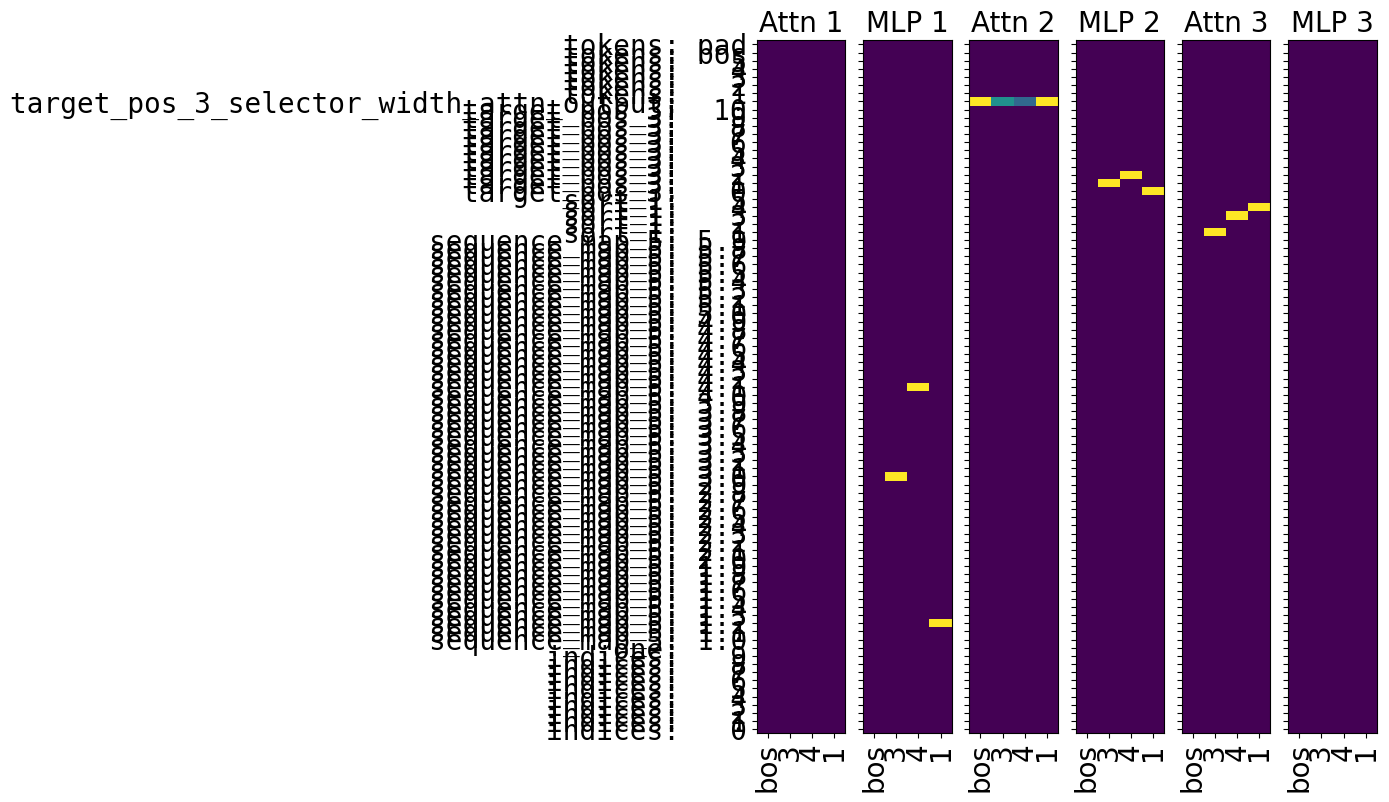

In [9]:
#@title Plot layer outputs
plot_layer_outputs(
  model=assembled_model,
  inputs = ["bos", 3, 4, 1],
  figsize=(8, 9)
)